##### This model follows the same fine tuning process as model 14, but with the init_lr, or learning rate initiated at the beginning of model training adjusted. The default init lr used in previous models is very low. Here we test the effect on a higher rate of model loss and overall performance and see if this also has an impact on overfitting and/or rouge scores.

# Imports

In [2]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, create_optimizer
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
import random
import matplotlib.pyplot as plt

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Read in data

In [4]:
data = load_dataset(
    'csv', data_files={
        'train':'./modeling_data/training_data.csv',
        'test':'./modeling_data/testing_data.csv',
        'validation':'./modeling_data/validation_data.csv'
        }
    )

Using custom data configuration default-74d066c3e8549d77


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-74d066c3e8549d77/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# Pre-process data for input to model
code from https://huggingface.co/course/chapter7/5?fw=tf

## Set up model tokenizer

In [5]:
model_checkpoint = 'sshleifer/distilbart-xsum-1-1'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

## Tokenize data

In [6]:
def preprocess_function(text_data):
  model_inputs = tokenizer(
      text_data['chapter_text'], max_length=1024, truncation=True)     

  with tokenizer.as_target_tokenizer():
    labels = tokenizer(
        text_data['chapter_summary'], max_length=1024, truncation=True)   
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [7]:
tokenized_data = data.map(preprocess_function)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

# Fine tune model

## Set up model

In [8]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/317M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at sshleifer/distilbart-xsum-1-1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


## Final processing of data for input to model

### Remove non-encoded columns from tokenized_data

In [9]:
tokenized_data_features = tokenized_data.remove_columns(
    data['train'].column_names
)

### Set up data collator to dynamically pad inputs and labels

In [10]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='tf')

### Use data collator to perform final processing on tokenized_data_features for input to model

In [11]:
tf_train = tokenized_data_features['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=1
)

tf_validation = tokenized_data_features['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

## Set up model hyperparamaters

In [13]:
num_train_epochs = 25
num_train_steps = len(tf_train) * num_train_epochs

optimizer, schedule = create_optimizer(
    init_lr=0.01,
    min_lr_ratio=.001,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.1,
)

## Compile model

In [14]:
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as keys in the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


## Fit model

In [15]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [16]:
model_history = model.fit(tf_train, validation_data=tf_validation, callbacks=[early_stop], epochs=25)

Epoch 1/25
212/212 [==============================] - 44s 156ms/step - loss: 7.5028 - val_loss: 7.0758
Epoch 2/25
212/212 [==============================] - 33s 154ms/step - loss: 6.8851 - val_loss: 6.9806
Epoch 3/25
212/212 [==============================] - 33s 158ms/step - loss: 6.8377 - val_loss: 6.9792
Epoch 4/25
212/212 [==============================] - 35s 162ms/step - loss: 6.8167 - val_loss: 6.9921
Epoch 5/25
212/212 [==============================] - 34s 160ms/step - loss: 6.7893 - val_loss: 7.0053
Epoch 6/25
212/212 [==============================] - 34s 161ms/step - loss: 6.7777 - val_loss: 6.9789
Epoch 7/25
212/212 [==============================] - 34s 161ms/step - loss: 6.7584 - val_loss: 6.9458
Epoch 8/25
212/212 [==============================] - 34s 162ms/step - loss: 6.7500 - val_loss: 6.9799
Epoch 9/25
212/212 [==============================] - 34s 161ms/step - loss: 6.7377 - val_loss: 6.9895
Epoch 10/25
212/212 [==============================] - 34s 162ms/step - l

# Visualize model

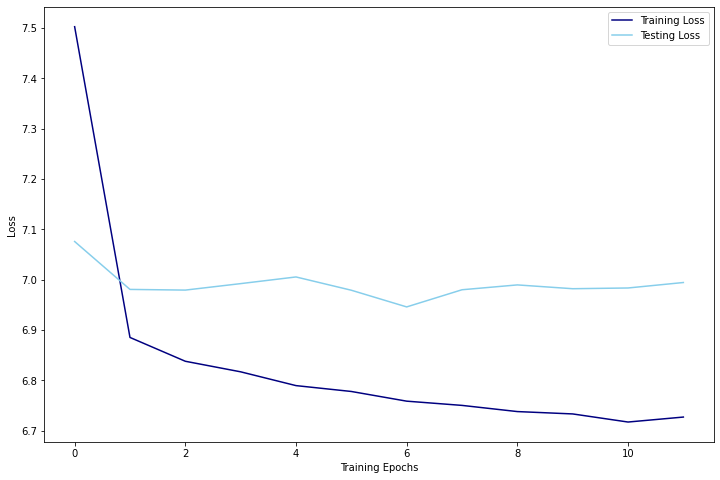

In [17]:
train_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(validation_loss, label='Testing Loss', color='skyblue')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend();

The loss functions of this model are closer together and more aligned than those of modle 14 and most of the other previous models, but the loss fuunction values are also much higher, indicating more error in the model.

# Rouge scores for training data

In [18]:
train_labels = []
train_preds = []

for batch in tqdm(tf_train):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    train_preds.extend(decoded_preds)
    train_labels.extend(decoded_labels)


100%|██████████| 212/212 [36:21<00:00, 10.29s/it]


In [19]:
rouge = load_metric('rouge')

train_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(train_results.keys()):
  mid_scores = train_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

Downloading:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

rouge1
precision: 74.07407407407408
recall: 7.547169811320755
f-measure: 13.698630136986301
***************
rouge2
precision: 3.8461538461538463
recall: 0.3787878787878788
f-measure: 0.6896551724137931
***************
rougeL
precision: 70.37037037037037
recall: 7.169811320754717
f-measure: 13.013698630136986
***************
rougeLsum
precision: 74.07407407407408
recall: 7.547169811320755
f-measure: 13.698630136986301
***************


# Rouge scores for test data

In [20]:
tf_test = tokenized_data_features['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'labels'],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=1
)

In [21]:
test_labels = []
test_preds = []

for batch in tqdm(tf_test):
    predictions = model.generate(batch['input_ids'])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    test_preds.extend(decoded_preds)
    test_labels.extend(decoded_labels)

100%|██████████| 59/59 [10:21<00:00, 10.54s/it]


In [22]:
rouge = load_metric('rouge')

test_results = rouge.compute(
    predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

for key in list(test_results.keys()):
  mid_scores = test_results[key].mid
  print(key)
  print(f'precision: {mid_scores[0]*100}')
  print(f'recall: {mid_scores[1]*100}')
  print(f'f-measure: {mid_scores[2]*100}')
  print('***************')

rouge1
precision: 70.37037037037037
recall: 8.296943231441048
f-measure: 14.84375
***************
rouge2
precision: 3.8461538461538463
recall: 0.43859649122807015
f-measure: 0.7874015748031495
***************
rougeL
precision: 66.66666666666666
recall: 7.860262008733625
f-measure: 14.0625
***************
rougeLsum
precision: 70.37037037037037
recall: 8.296943231441048
f-measure: 14.84375
***************


# Example model-generated summaries

In [23]:
rand_indexes = []
for i in range(3):
  rand_indexes.append(random.randint(0,59))

In [24]:
print(rand_indexes)

[34, 17, 2]


In [25]:
print(test_labels[34])

Fagin was condemned to hang in court and was taken to a cell where he was confined until the day he died.
On the last day, Oliver and Mr. Brownlow came to visit to find out the location of papers they needed from him.
Oliver says goodbye to Fagin.
Harry and Rose were married and moved to their happy home.
Oliver and Monks split the inheritance and Monks takes his share to the New World where he squanders it and eventually dies in prison.
Mr. Brownlow adopts Oliver and imparts much knowledge on him.
Noah is pardoned for his help in catching the murderers, and Charley Bates turns his back on the life of crime and grows up an honest man.
All of them are happy and the past is finally put to rest.


In [26]:
print(test_preds[34])

,,,.,..,, the., the,.
the, the the the... the.
the the,, to, the to,.
to,, and., to the, to., and, the and,.
and.. to.
the to


In [27]:
print(test_labels[17])

Goneril meets with the steward of her household, Oswald, to complain about her father who's come to stay with her.
She tells him that he should be cold to her father and his knights.
If her father asks for her, he should tell him that she is ill.
The banished Earl of Kent disguises himself and goes to Goneril's court to serve Lear.
Lear accepts him, and together they talk to the Fool who insults Lear.
He thinks, like Kent, that he made the wrong decision about Cordelia.
Oswald enters and gives Lear the cold shoulder, and Kent trips him forever sealing his place at Lear's side.
After a while, Goneril enters and berates her father about his knights.
She upbraids him and tells him that he should dispatch some of his knights.
Again, Lear is insulted at her treatment of him.
He decides to send away half of his entourage, and move as soon as possible to his other daughters house.
Lear has begun to regret disowning Cordelia because of the way his eldest daughter treats him.


In [28]:
print(test_preds[17])

,,,.,..,, the., the,.
the... the, the the,, to., to,.
to, the to,, and the, to the, and.
the the the.
to.. to the.
the to the the to


In [29]:
print(test_labels[2])

Duke Frederick finds that Celia, Rosalind, and Touchstone are missing.
One of Celia's attendants tells him that she overheard the girls talking about Orlando, and that he is probably with them wherever they are.
The Duke sends men to Orlando's house to find him and bring him back.
While Orlando is at home, his servant and friend Adam, who is much older than he, tells him that his brother is planning to kill him.
Oliver is jealous of his successes wrestling, and sick of supporting him.
Adam warns Orlando to leave, but Orlando does not know where to go.
Adam then offers him the money he has saved for his old age.
Orlando does not want to take it, but they decide they will leave together.


In [30]:
print(test_preds[2])

,,,.,, the,..., the.,.
the, the the.
the the,, to., to,.
to, the to,, and the, to the, and.. the.. to.
the to the.
to the the to.


# Evaluation of model

This model did not perform well. Rouges scores were lower or similar to the baseline. Additionally, it is clear from the example generated summaries that this model is not succeeding in extracting relevant content from reference texts. The summaries produced are seem to be composed only of 1-3 words found very commonly in the texts